In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum, LinExpr
import eat
import graphviz
from IPython.display import Image, display

In [2]:
Xa = np.random.choice(np.concatenate([np.arange(-50, 0), np.arange(1, 51)]), size=(100, 3))
Xb = np.random.choice(np.concatenate([np.arange(-50, 0), np.arange(1, 51)]), size=(50, 3))

Ya = np.random.choice(np.concatenate([np.arange(-50, 0), np.arange(1, 5)]), size=(100, 3))
Yb = np.random.choice(np.concatenate([np.arange(-50, 0), np.arange(1, 51)]), size=(50, 1))

dataA = np.concat([Xa, Ya], axis=1)
dataB = np.concat([Xb, Yb], axis=1)

columns_A = ['x1', 'x2', 'x3', 'y1', 'y2', 'y3']
columns_B = ['x1', 'x2', 'x3', 'y1']

dfA = pd.DataFrame(dataA, columns=columns_A)
dfB = pd.DataFrame(dataB, columns=columns_B)

dfA['DMU'] = np.arange(dfA.shape[0])
dfB['DMU'] = np.arange(dfB.shape[0])

In [3]:
tree1 = eat.EAT(dfA, ['x1', 'x2', 'x3'], ['y1', 'y2', 'y3'], numStop=10, fold=5)
tree2 = eat.EAT(dfB, ['x1', 'x2', 'x3'], ['y1'], numStop=10, fold=5)

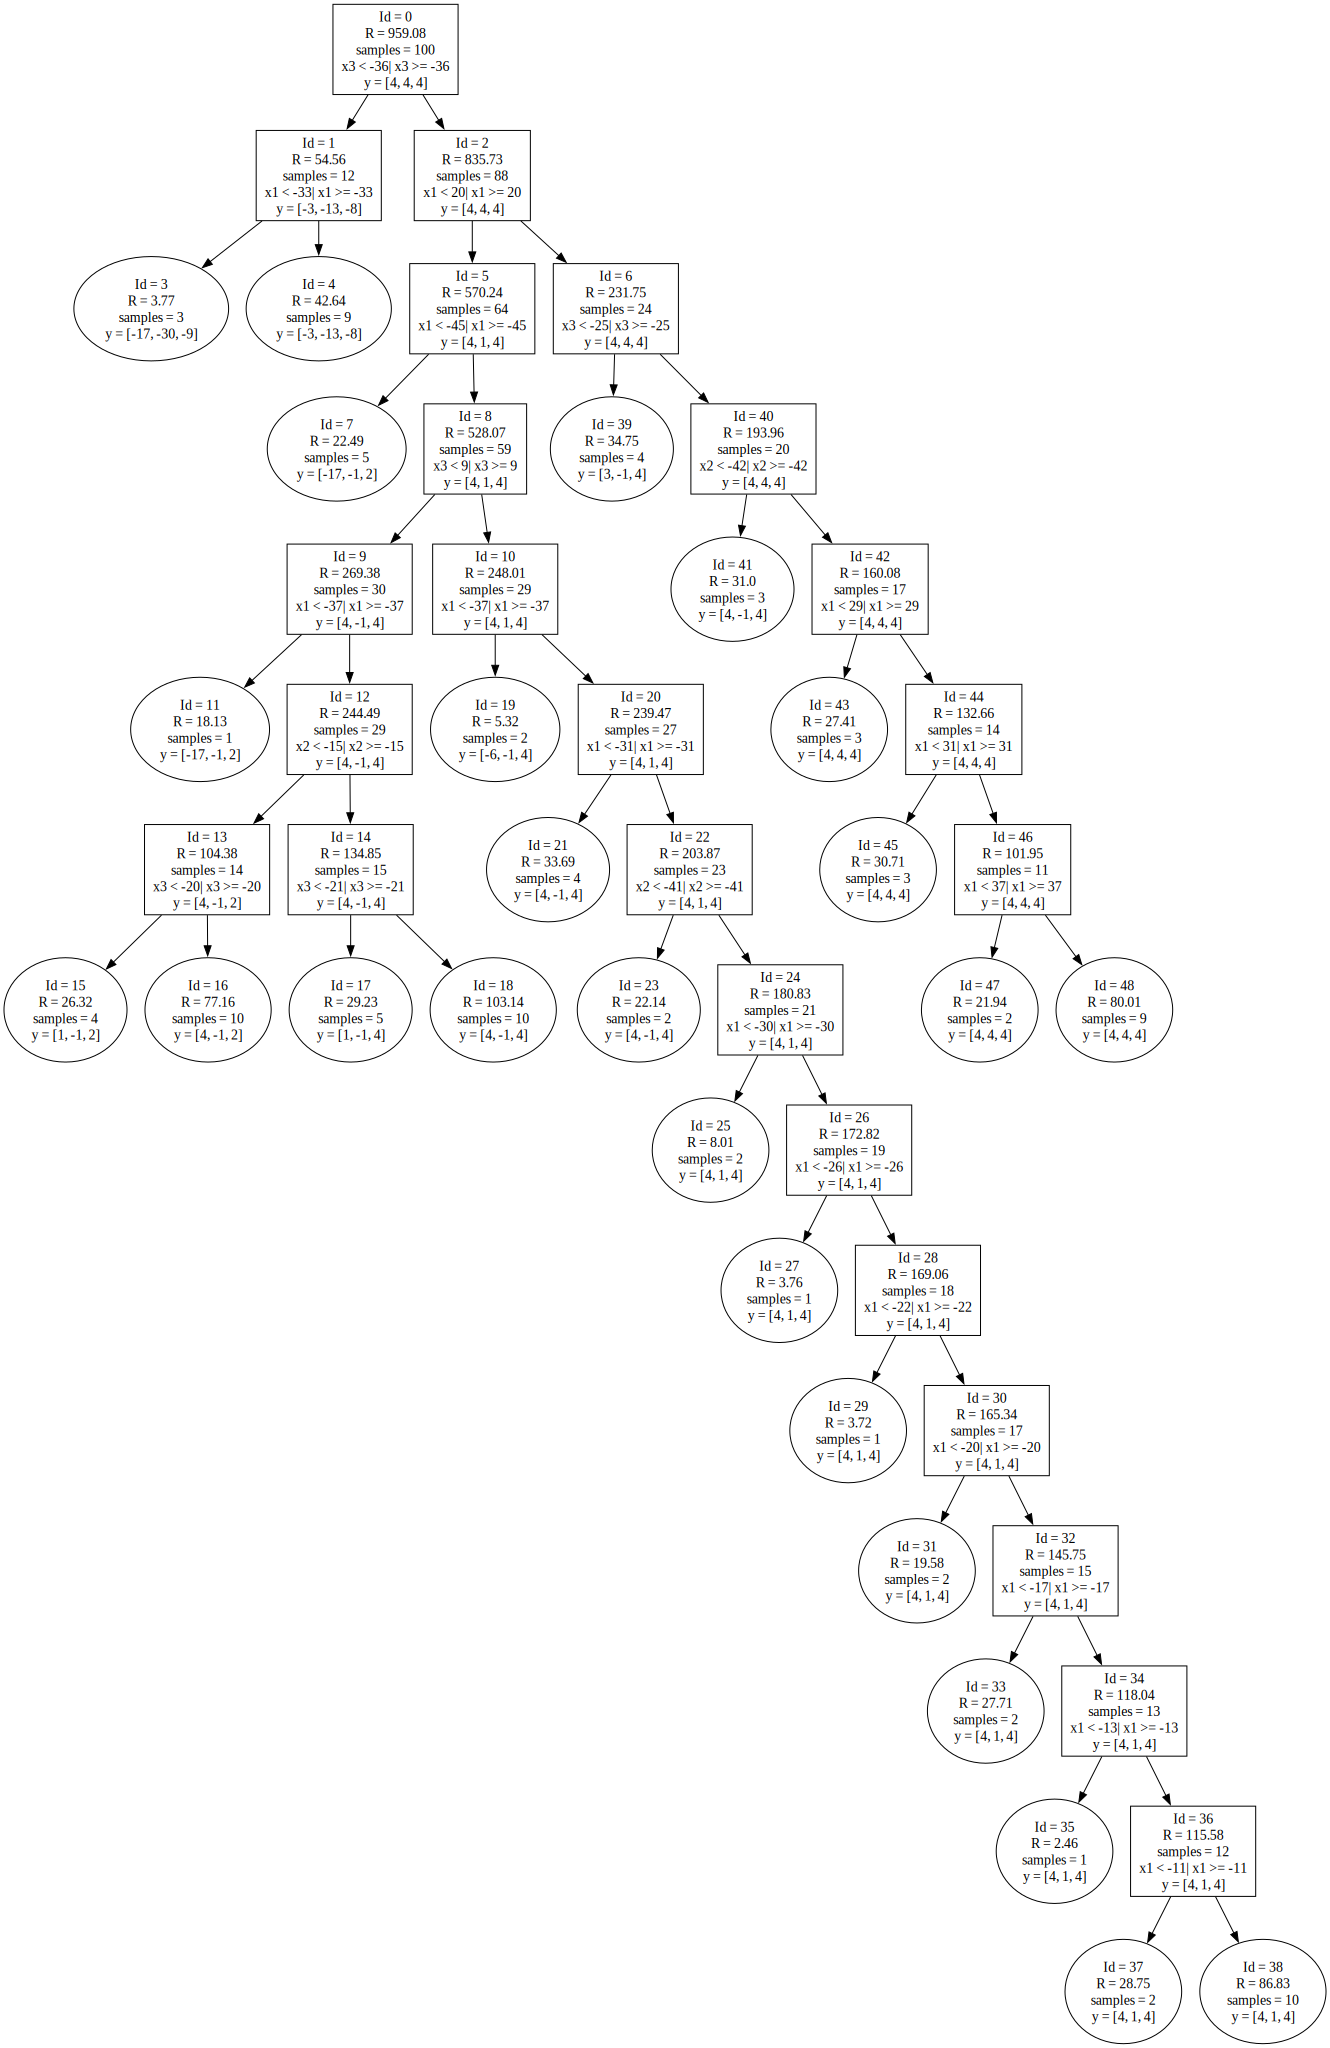

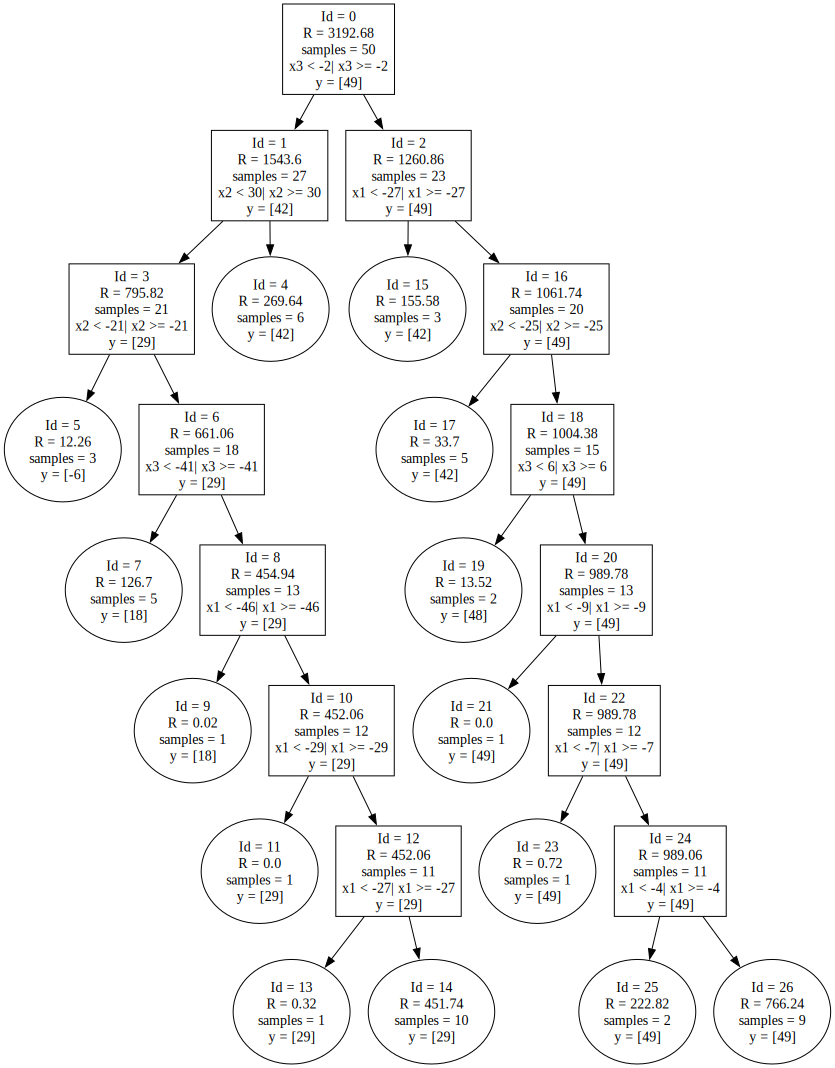

In [4]:
dot_data1 = tree1.export_graphviz('Tree 1')
graph1 = graphviz.Source(dot_data1)
display(graph1)  

dot_data2 = tree2.export_graphviz('Tree 2')
graph2 = graphviz.Source(dot_data2)
display(graph2)  

In [5]:
dot_data1 = tree1.export_graphviz('Tree 1')
with open(".\tree1.dot", "w") as f:
    f.write(dot_data1)

In [5]:
def TreeDMUs(tree):
    res = {}
    for node in tree.tree:
        if node.get("SL") == -1:
            res[node["id"]] = {"dmus":node["index"],
                               'a': node['a'],
                               'b': node['b'],
                               'y': node['y']}
    return res


In [6]:
treeleaf1 = TreeDMUs(tree1)
treeleaf2 = TreeDMUs(tree2)

In [7]:
treeleaf2

{3: {'dmus': array([ 4, 19, 22, 38, 39, 40]),
  'a': [-49, -50, -46],
  'b': [-40, inf, inf],
  'y': [-3]},
 4: {'dmus': array([ 0,  1,  2, 13, 18, 21, 26, 33, 44, 48]),
  'a': [-40, -50, -46],
  'b': [-23, inf, inf],
  'y': [31]},
 5: {'dmus': array([ 3,  5,  7, 17, 31, 37, 41, 42, 43]),
  'a': [-23, -50, -46],
  'b': [inf, inf, -32],
  'y': [33]},
 7: {'dmus': array([ 8, 10, 16, 27, 47]),
  'a': [-23, -50, -32],
  'b': [inf, -30, inf],
  'y': [33]},
 9: {'dmus': array([12, 20, 29, 46]),
  'a': [-23, -30, -32],
  'b': [inf, inf, -15],
  'y': [39]},
 11: {'dmus': array([ 6, 14, 15, 23, 25, 28, 36, 45]),
  'a': [-23, -30, -15],
  'b': [11, inf, inf],
  'y': [46]},
 12: {'dmus': array([ 9, 11, 24, 30, 32, 34, 35, 49]),
  'a': [11, -30, -15],
  'b': [inf, inf, inf],
  'y': [48]}}

In [8]:
nodes1, a1, d_T1 = {}, [], []
for idx, leaf in enumerate(treeleaf1):
    nodes1[idx] = treeleaf1[leaf]['dmus'].tolist()
    a1.append(treeleaf1[leaf]['a'])
    d_T1.append(treeleaf1[leaf]['y'])

a1 = np.array(a1)
d_T1 = np.array(d_T1)

nodes2, a2, d_T2 = {}, [], []
for idx, leaf in enumerate(treeleaf2):
    nodes2[idx] = treeleaf2[leaf]['dmus'].tolist()
    a2.append(treeleaf2[leaf]['a'])
    d_T2.append(treeleaf2[leaf]['y'])

a2 = np.array(a2)
d_T2 = np.array(d_T2)


In [9]:
nodes2

{0: [4, 19, 22, 38, 39, 40],
 1: [0, 1, 2, 13, 18, 21, 26, 33, 44, 48],
 2: [3, 5, 7, 17, 31, 37, 41, 42, 43],
 3: [8, 10, 16, 27, 47],
 4: [12, 20, 29, 46],
 5: [6, 14, 15, 23, 25, 28, 36, 45],
 6: [9, 11, 24, 30, 32, 34, 35, 49]}

In [10]:
a2

array([[-49, -50, -46],
       [-40, -50, -46],
       [-23, -50, -46],
       [-23, -50, -32],
       [-23, -30, -32],
       [-23, -30, -15],
       [ 11, -30, -15]])

In [11]:
d_T2

array([[-3],
       [31],
       [33],
       [33],
       [39],
       [46],
       [48]])

In [12]:
dfa_selected = dfA[['x1', 'x2', 'x3']]
dfb_selected = dfB[['x1', 'x2', 'x3']]
x = np.concatenate([dfa_selected.values, dfb_selected.values], axis=0)

In [13]:
x.shape

(150, 3)

In [14]:
dfa_selected = dfA[['y1', 'y2', 'y3']]
dfb_selected = np.concatenate([dfB[['y1']].values, np.zeros((50, 2))], axis=1)
y = np.concatenate([dfa_selected, dfb_selected], axis=0)

In [15]:
y.shape

(150, 3)

In [16]:
Efficiencies = {}

In [17]:
#RDM
N1=list(range(0,100))
N2=list(range(100, 150))

R1=[0]
R2=[1,2]

N1_bar=list(range(0,150))
N2_bar=list(range(0,100))
m=3
q=3
n=150


alphas=[]
betas=[]
Results=[]
lambdas_1=[]

for o in N1:
    alpha = {}
    beta = {}
    lambdas = {}
    model = Model("DMU_Optimization")
    for i in range(m):
        for j in N1:
            alpha[i, j] = model.addVar(vtype=GRB.CONTINUOUS, lb=0.6, ub=0.85, name=f"alpha_{i}_{j}_0")
    beta[o, 0] = model.addVar(vtype=GRB.CONTINUOUS, lb=0,ub=1, name=f"beta_{j}_0")
    beta[o, 1] = model.addVar(vtype=GRB.CONTINUOUS,lb=0,ub=1, name=f"beta_{j}_1")

    for j in N1_bar:
        lambdas[j, 0] = model.addVar(vtype=GRB.CONTINUOUS,lb=0, ub=1, name=f"lambda_{j}_0")
    for j in N2_bar:
        lambdas[j, 1] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f"lambda_{j}_1")

 
    model.setParam('DualReductions', 0)
    model.setObjective(
   (beta[o, 0] + beta[o,1])/2, GRB.MAXIMIZE
)
   
    
    R_minus = [x[o, i] - min(x[:, i]) for i in range(m)]
    R_plus = [max(y[:, r]) - y[o, r] for r in range(q)]
     

    model.addConstr(
            quicksum(lambdas[j, 0] * y[j,0] for j in N1_bar) >= y[o,0] + beta[o, 0] * R_plus[0]
        )
    model.addConstr(
            quicksum(lambdas[j, 1] * y[j,1] for j in N2_bar) >= y[o,1] + beta[o, 1] * R_plus[1]
        )
    model.addConstr(
            quicksum(lambdas[j, 1] * y[j,2] for j in N2_bar) >= y[o,2] + beta[o, 1] * R_plus[2]
        )
    

    for i in range(m):  

        model.addConstr(
                quicksum(lambdas[j, 0] * alpha[i, j] * x[j,i] for j in N1) + quicksum(lambdas[j, 0] * x[j,i] for j in N2)
                <= alpha[i, o] * x[o,i] - beta[o, 0] * alpha[i, o] * R_minus[i]
            )
        
        model.addConstr(
                quicksum(lambdas[j, 1] * (1-alpha[i, j]) * x[j,i] for j in N1)
                <= (1-alpha[i, o]) * x[o,i] - beta[o, 1] * (1-alpha[i, o]) * R_minus[i]
            )
        
    model.addConstr(quicksum(lambdas[j, 0] for j in N1_bar) == 1)
    model.addConstr(quicksum(lambdas[j, 1] for j in N2_bar) == 1)

    model.optimize()

    if model.status == GRB.OPTIMAL:
        alpha_values1 = model.getAttr("x", alpha)
        beta_values1 = model.getAttr("x", beta)
        lambda_values1 = model.getAttr("x", lambdas)
        for key, value in alpha_values1.items():
            if key[1]==o:
                    alphas.append({
                            "DMU": o,
                            "alphas_RDM": {'key':key, 'value': value}
                        })
        for key,value in lambda_values1.items():
            lambdas_1.append({
                            "DMU": o,
                            "lambda": {'key':key, 'value': value}
                        })
        for key, value in beta_values1.items():
            if key[0]==o:
                betas.append({
                            "DMU": o,
                            "betas": {'key':key, 'value': value}
                        })
                
        objective_value = model.objVal
        Results.append({"DMU":o, "efficiency_RDM":1-objective_value})
    else:
        print("No optimal solution found.")


dmu_values = {}
for item in alphas:
    dmu = item['DMU']
    value = item['alphas_RDM']['value']
    dmu_values.setdefault(dmu, []).append(value)
values_list = list(dmu_values.values())



for o in N2:
    alpha = {}
    beta = {}
    lambdas = {}
    model = Model("DMU_Optimization")
    for i in range(m):
        for j in N1:
            alpha[i, j] = model.addVar(vtype=GRB.CONTINUOUS, lb=0.6, ub=0.85, name=f"alpha_{i}_{j}_0")
    beta[o, 0] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1,name=f"beta_{j}_0")

    for j in N1_bar:
        lambdas[j, 0] = model.addVar(vtype=GRB.CONTINUOUS,lb=0, ub=1,name=f"lambda_{j}_0")

    model.setParam('DualReductions', 0)
    model.setObjective(
   (beta[o, 0]), GRB.MAXIMIZE
)
    
    R_minus = [x[o, i] - min(x[:, i]) for i in range(m)]
    R_plus = [max(y[:, r]) - y[o, r] for r in range(q)]

    model.addConstr(
            quicksum(lambdas[j, 0] * y[j,0] for j in N1_bar) >= y[o,0] + beta[o, 0] * R_plus[0]
        )
    
    for i in range(m):  

        model.addConstr(
                quicksum(lambdas[j, 0] * values_list[j][i] * x[j,i] for j in N1) + quicksum(lambdas[j, 0] * x[j,i] for j in N2)
                <=  x[o,i] - beta[o, 0]* R_minus[i]
            )
        
    model.addConstr(quicksum(lambdas[j, 0] for j in N1_bar) == 1)


   
    
    model.optimize()

    if model.status == GRB.OPTIMAL:
        alpha_values1 = model.getAttr("x", alpha)
        beta_values1 = model.getAttr("x", beta)
        lambda_values1 = model.getAttr("x", lambdas)
        for key, value in alpha_values1.items():
            if key[1]==o:
                    alphas.append({
                            "DMU": o,
                            "alphas": {'key':key, 'value': value}
                        })
        for key,value in lambda_values1.items():
            lambdas_1.append({
                            "DMU": o,
                            "lambda": {'key':key, 'value': value}
                        })
        for key, value in beta_values1.items():
            if key[0]==o:
                betas.append({
                            "DMU": o,
                            "betas": {'key':key, 'value': value}
                        })
                
        objective_value = model.objVal
        Results.append({"DMU":o, "efficiency_RDM":1-objective_value})
    else:
        print("No optimal solution found.")
Efficiencies['RDM'] = Results
Results

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2579375
Academic license 2579375 - for non-commercial use only - registered to ma___@iitd.ac.in
Set parameter DualReductions to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2579375 - for non-commercial use only - registered to ma___@iitd.ac.in
Optimize a model with 5 rows, 552 columns and 603 nonzeros
Model fingerprint: 0x6393bb0d
Model has 6 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  QMatrix range    [1e+00, 9e+01]
  QLMatrix range   [1e+00, 9e+01]
  Objective range  [5e-01, 5e-01]
  Bounds range     [6e-01, 1e+00]
  RHS range        [1e+00, 5e+01]
  QRHS range       [1e+01, 4e+01]

Continuous model is non-convex -- solving as a MIP

Presolve time: 0.00s
Presolved: 1223 rows, 1158 columns, 4688 nonzeros
Pr

[{'DMU': 0, 'efficiency_RDM': 0.16626656759098102},
 {'DMU': 1, 'efficiency_RDM': 0.22814559403006696},
 {'DMU': 2, 'efficiency_RDM': 0.16067732954388214},
 {'DMU': 3, 'efficiency_RDM': 0.2230376646690676},
 {'DMU': 4, 'efficiency_RDM': 0.19670206682240043},
 {'DMU': 5, 'efficiency_RDM': 0.20373314858983183},
 {'DMU': 6, 'efficiency_RDM': 0.2582234370726474},
 {'DMU': 7, 'efficiency_RDM': 0.3770222856036788},
 {'DMU': 8, 'efficiency_RDM': 0.21588471879714877},
 {'DMU': 9, 'efficiency_RDM': 0.16180910237077006},
 {'DMU': 10, 'efficiency_RDM': 0.27774403295561645},
 {'DMU': 11, 'efficiency_RDM': 0.14500504567305872},
 {'DMU': 12, 'efficiency_RDM': 0.19546945429240004},
 {'DMU': 13, 'efficiency_RDM': 0.3138714721843927},
 {'DMU': 14, 'efficiency_RDM': 0.15525842936247614},
 {'DMU': 15, 'efficiency_RDM': 0.17293898048034761},
 {'DMU': 16, 'efficiency_RDM': 0.22085481668979745},
 {'DMU': 17, 'efficiency_RDM': 0.15917825599956215},
 {'DMU': 18, 'efficiency_RDM': 0.38376894173400855},
 {'DMU'

In [18]:
# RDM FDH
Nalphas=[]
betas=[]
Results=[]
lambdas_1=[]
alphas = []
for o in N1:
    alpha = {}
    beta = {}
    lambdas = {}
    model = Model("DMU_Optimization")
    for i in range(m):
        for j in N1:
            alpha[i, j] = model.addVar(vtype=GRB.CONTINUOUS, lb=0.6, ub=0.85, name=f"alpha_{i}_{j}_0")
    beta[o, 0] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f"beta_{j}_0")
    beta[o, 1] = model.addVar(vtype=GRB.CONTINUOUS,  lb=0, ub=1,name=f"beta_{j}_1")

    for j in N1_bar:
        lambdas[j, 0] = model.addVar(vtype=GRB.BINARY,lb=0, ub=1, name=f"lambda_{j}_0")
    for j in N2_bar:
        lambdas[j, 1] = model.addVar(vtype=GRB.BINARY, lb=0, ub=1, name=f"lambda_{j}_1") 

 
    model.setParam('DualReductions', 0)
    model.setObjective(
   (beta[o, 0] + beta[o,1])/2, GRB.MAXIMIZE
)
    
    R_minus = [x[o, i] - min(x[:, i]) for i in range(m)]
    R_plus = [max(y[:, r]) - y[o, r] for r in range(q)]
     
    model.addConstr(
            quicksum(lambdas[j, 0] * y[j,0] for j in N1_bar) >= y[o,0] + beta[o, 0] * R_plus[0]
        )
    model.addConstr(
            quicksum(lambdas[j, 1] * y[j,1] for j in N2_bar) >= y[o,1] + beta[o, 1] * R_plus[1]
        )
    model.addConstr(
            quicksum(lambdas[j, 1] * y[j,2] for j in N2_bar) >= y[o,2] + beta[o, 1] * R_plus[2]
        )
   

    for i in range(m):  

        model.addConstr(
                quicksum(lambdas[j, 0] * alpha[i, j] * x[j,i] for j in N1) + quicksum(lambdas[j, 0] * x[j,i] for j in N2)
                <= alpha[i, o] * x[o,i] - beta[o, 0] * alpha[i, o] * R_minus[i]
            )
        model.addConstr(
                quicksum(lambdas[j, 1] * (1-alpha[i, j]) * x[j,i] for j in N1)
                <= (1-alpha[i, o]) * x[o,i] - beta[o, 1] * (1-alpha[i, o]) * R_minus[i]
            )
        
    model.addConstr(quicksum(lambdas[j, 0] for j in N1_bar) == 1)
    model.addConstr(quicksum(lambdas[j, 1] for j in N2_bar) == 1)

    model.optimize()

    if model.status == GRB.OPTIMAL:
        alpha_values1 = model.getAttr("x", alpha)
        beta_values1 = model.getAttr("x", beta)
        lambda_values1 = model.getAttr("x", lambdas)
        for key, value in alpha_values1.items():
            if key[1]==o:
                    alphas.append({
                            "DMU": o,
                            "alphas_RDM_FDH": {'key':key, 'value': value}
                        })
        for key,value in lambda_values1.items():
            lambdas_1.append({
                            "DMU": o,
                            "lambda": {'key':key, 'value': value}
                        })
        for key, value in beta_values1.items():
            if key[0]==o:
                betas.append({
                            "DMU": o,
                            "betas": {'key':key, 'value': value}
                        })
                
        objective_value = model.objVal
        Results.append({"DMU":o, "efficiency_RDM_FDH":1-objective_value})
    else:
        print("No optimal solution found.")

dmu_values = {}
for item in alphas:
    print(item)
    dmu = item['DMU']
    value = item['alphas_RDM_FDH']['value']
    dmu_values.setdefault(dmu, []).append(value)
values_list = list(dmu_values.values())


for o in N2:
    alpha = {}
    beta = {}
    lambdas = {}
    model = Model("DMU_Optimization")
    for i in range(m):
        for j in N1:
            alpha[i, j] = model.addVar(vtype=GRB.CONTINUOUS, lb=0.1, ub=0.4, name=f"alpha_{i}_{j}_0")
    beta[o, 0] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f"beta_{j}_0")

    for j in N1_bar:
        lambdas[j, 0] = model.addVar(vtype=GRB.BINARY,lb=0, ub=1, name=f"lambda_{j}_0")  

 
    model.setParam('DualReductions', 0)
    model.setObjective(
   (beta[o, 0]), GRB.MAXIMIZE
)
    
    R_minus = [x[o, i] - min(x[:, i]) for i in range(m)]
    R_plus = [max(y[:, r]) - y[o, r] for r in range(q)]

    model.addConstr(
            quicksum(lambdas[j, 0] * y[j,0] for j in N1_bar) >= y[o,0] + beta[o, 0] * R_plus[0]
        )

    for i in range(m):  
        model.addConstr(
                quicksum(lambdas[j, 0] * values_list[j][i] * x[j,i] for j in N1) + quicksum(lambdas[j, 0] * x[j,i] for j in N2)
                <=  x[o,i] - beta[o, 0]* R_minus[i]
            )
        
    model.addConstr(quicksum(lambdas[j, 0] for j in N1_bar) == 1)
    
    model.optimize()

    if model.status == GRB.OPTIMAL:
        alpha_values1 = model.getAttr("x", alpha)
        beta_values1 = model.getAttr("x", beta)
        lambda_values1 = model.getAttr("x", lambdas)
        for key, value in alpha_values1.items():
            if key[1]==o:
                    alphas.append({
                            "DMU": o,
                            "alphas": {'key':key, 'value': value}
                        })
        for key,value in lambda_values1.items():
            lambdas_1.append({
                            "DMU": o,
                            "lambda": {'key':key, 'value': value}
                        })
        for key, value in beta_values1.items():
            if key[0]==o:
                betas.append({
                            "DMU": o,
                            "betas": {'key':key, 'value': value}
                        })
                
        objective_value = model.objVal
        Results.append({"DMU":o, "efficiency_RDM_FDH":1-objective_value})

    else:
        print("No optimal solution found.")
Efficiencies['RDMFDH'] = Results
Results

Set parameter DualReductions to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2579375 - for non-commercial use only - registered to ma___@iitd.ac.in
Optimize a model with 5 rows, 552 columns and 603 nonzeros
Model fingerprint: 0x1dd61b53
Model has 6 quadratic constraints
Variable types: 302 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  QMatrix range    [1e+00, 9e+01]
  QLMatrix range   [1e+00, 9e+01]
  Objective range  [5e-01, 5e-01]
  Bounds range     [6e-01, 1e+00]
  RHS range        [1e+00, 5e+01]
  QRHS range       [1e+01, 4e+01]
Presolve removed 0 rows and 98 columns
Presolve time: 0.00s
Presolved: 573 rows, 823 columns, 2531 nonzeros
Presolved model has 6 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 671 continuous, 152 integer (152 binary)

Root relax

[{'DMU': 0, 'efficiency_RDM_FDH': 0.23786569131314805},
 {'DMU': 1, 'efficiency_RDM_FDH': 0.29429559204840106},
 {'DMU': 2, 'efficiency_RDM_FDH': 0.226513098464318},
 {'DMU': 3, 'efficiency_RDM_FDH': 0.26824946846203823},
 {'DMU': 4, 'efficiency_RDM_FDH': 0.24721293199549266},
 {'DMU': 5, 'efficiency_RDM_FDH': 0.28682487725040917},
 {'DMU': 6, 'efficiency_RDM_FDH': 0.3785310732841807},
 {'DMU': 7, 'efficiency_RDM_FDH': 0.43106312292358806},
 {'DMU': 8, 'efficiency_RDM_FDH': 0.28689624329152164},
 {'DMU': 9, 'efficiency_RDM_FDH': 0.2108843537414966},
 {'DMU': 10, 'efficiency_RDM_FDH': 0.3660714285714286},
 {'DMU': 11, 'efficiency_RDM_FDH': 0.20082101806235408},
 {'DMU': 12, 'efficiency_RDM_FDH': 0.32853535353535346},
 {'DMU': 13, 'efficiency_RDM_FDH': 0.5171568627450981},
 {'DMU': 14, 'efficiency_RDM_FDH': 0.204890853827024},
 {'DMU': 15, 'efficiency_RDM_FDH': 0.28161290322580645},
 {'DMU': 16, 'efficiency_RDM_FDH': 0.3035714285714286},
 {'DMU': 17, 'efficiency_RDM_FDH': 0.1904761904761

In [19]:
#EAT FDH
alphas=[]
betas=[]
Results=[]
lambdas_1=[]

for o in N1:
    alpha = {}
    beta = {}
    lambdas = {}
    lambdas_dash={}
    model = Model("DMU_Optimization")
    for t in nodes1:
        alpha[t] = model.addVar(vtype=GRB.CONTINUOUS, lb=0.6, ub=0.85, name=f"alpha_{t}_0")

    beta[o, 0] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"beta_{o}_0")
    beta[o, 1] = model.addVar(vtype=GRB.CONTINUOUS,  lb=0,name=f"beta_{o}_1")

    for t in nodes1:
        lambdas[t, 0] = model.addVar(vtype=GRB.BINARY, name=f"lambda_{t}_0")
    for t in nodes2:
        lambdas_dash[t, 0] = model.addVar(vtype=GRB.BINARY, name=f"lambda_dash_{t}_0")
    for t in nodes1:
        lambdas[t, 1] = model.addVar(vtype=GRB.BINARY, name=f"lambda_{t}_1")


 
    model.setParam('DualReductions', 0)
    model.setObjective(
   (beta[o, 0] + beta[o,1])/2, GRB.MAXIMIZE
)
    
    R_minus = [x[o, i] - min(x[:, i]) for i in range(m)]
    R_plus = [max(y[:, r]) - y[o, r] for r in range(q)]
      
    model.addConstr(
                        quicksum(lambdas[t1, 0] * d_T1[t1,0] for t1 in nodes1) + quicksum(lambdas_dash[t2, 0] * d_T2[t2][0] for t2 in nodes2) >= y[o,0] + beta[o, 0] * R_plus[0]
                    )
            
    model.addConstr(
                        quicksum(lambdas[t, 1] * d_T1[t,1] for t in nodes1) >= y[o,1] + beta[o, 1] * R_plus[1]
                    )   
    model.addConstr(
                        quicksum(lambdas[t, 1] * d_T1[t,2] for t in nodes1) >= y[o,2] + beta[o, 1] * R_plus[2]
                    )  
    
    alpha_knot = alpha[next((key for key, values in nodes1.items() if o in values), None)]
    for i in range(m):  

            model.addConstr(
                    quicksum(lambdas[t, 0] * alpha[t] * a1[t,i] for t in nodes1) + quicksum(lambdas_dash[t, 0] * a2[t,i] for t in nodes2)
                    <= alpha_knot * x[o,i] - beta[o, 0] * alpha_knot * R_minus[i]
                )
            model.addConstr(
                    quicksum(lambdas[t, 1] * (1-alpha[t]) * a1[t,i] for t in nodes1)
                    <= (1-alpha_knot) * x[o,i] - beta[o, 1] * (1-alpha_knot) * R_minus[i]
                )
            
    model.addConstr(quicksum(lambdas[t, 0] for t in nodes1)+ quicksum(lambdas_dash[t, 0] for t in nodes2)== 1)
    model.addConstr(quicksum(lambdas[t, 1] for t in nodes1)== 1)
    
    model.optimize()

    if model.status == GRB.OPTIMAL:
        alpha_values1 = model.getAttr("x", alpha)
        beta_values1 = model.getAttr("x", beta)
        lambda_values1 = model.getAttr("x", lambdas)
        for key, value in alpha_values1.items():
               if key==next((key for key, values in nodes1.items() if o in values), None):
                    alphas.append({
                                        "DMU": o,
                                        "alphas": {'key':key, 'value': value}
                                    })
        for key,value in lambda_values1.items():
            lambdas_1.append({
                            "DMU": o,
                            "lambda": {'key':key, 'value': value}
                        })
        for key, value in beta_values1.items():
            if key[0]==o:
                betas.append({
                            "DMU": o,
                            "betas": {'key':key, 'value': value}
                        })
                
        objective_value = model.objVal
        Results.append({"DMU":o, "efficiency_EAT_FDH":
                        1-objective_value})
    else:
        print("No optimal solution found.")





alpha_node=[]
from collections import defaultdict
alpha_sums = defaultdict(float)
alpha_counts = defaultdict(int)
def calculate_average_alphas(data):
    for item in data:
        key = item['alphas']['key']
        value = item['alphas']['value']
        alpha_sums[key] += value
        alpha_counts[key] += 1

    average_alphas = {key: alpha_sums[key] / alpha_counts[key] for key in alpha_sums}
    for key in average_alphas:
        alpha_node.append(average_alphas[key])
    return alpha_node
alpha_node = calculate_average_alphas(alphas)
print(alpha_node)




for o in N2:
    alpha = {}
    beta = {}
    lambdas = {}
    model = Model("DMU_Optimization")
    beta[o, 0] = model.addVar(vtype=GRB.CONTINUOUS, lb=0,name=f"beta_{o}_0")

    for t in nodes1:
        lambdas[t, 0] = model.addVar(vtype=GRB.BINARY,lb=0,ub=1, name=f"lambda_{t}_0")
    for t in nodes2:
        lambdas_dash[t, 0] = model.addVar(vtype=GRB.BINARY, lb=0,ub=1,name=f"lambda_dash_{t}_0")


 
    model.setParam('DualReductions', 0)
    model.setObjective(
   (beta[o, 0]), GRB.MAXIMIZE
)
    
    
    R_minus = [x[o, i] - min(x[:, i]) for i in range(m)]
    R_plus = [max(y[:, r]) - y[o, r] for r in range(q)]
    
    model.addConstr(
            quicksum(lambdas[t, 0] * d_T1[t,0] for t in nodes1)+quicksum(lambdas_dash[t, 0] * d_T2[t,0] for t in nodes2) >= y[o,0] + beta[o, 0] * R_plus[0]
        )
    
    for i in range(m):  
        
     
        model.addConstr(
                quicksum(lambdas[t, 0] *alpha_node[t]*a1[t,i] for t in nodes1) + quicksum(lambdas_dash[t, 0] * a2[t,i] for t in nodes2)
                <=  x[o,i] - beta[o, 0]* R_minus[i]
            )
        
    model.addConstr(quicksum(lambdas[t, 0] for t in nodes1)+ quicksum(lambdas_dash[t, 0] for t in nodes2)== 1)

    model.optimize()

    if model.status == GRB.OPTIMAL:
        alpha_values1 = model.getAttr("x", alpha)
        beta_values1 = model.getAttr("x", beta)
        lambda_values1 = model.getAttr("x", lambdas)
        for key, value in alpha_values1.items():
                    alphas.append({
                            "DMU": o,
                            "alphas": {'key':key, 'value': value}
                        })
        
        
        for key,value in lambda_values1.items():
            lambdas_1.append({
                            "DMU": o,
                            "lambda": {'key':key, 'value': value}
                        })
        for key, value in beta_values1.items():
            if key[0]==o:
                betas.append({
                            "DMU": o,
                            "betas": {'key':key, 'value': value}
                        })
                
        objective_value = model.objVal
        Results.append({"DMU":o, "efficiency_EAT_FDH":1-objective_value})

    
    else:
        print("No optimal solution found.")

Efficiencies['EATFDH'] = Results
Results

Set parameter DualReductions to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2579375 - for non-commercial use only - registered to ma___@iitd.ac.in
Optimize a model with 5 rows, 90 columns and 152 nonzeros
Model fingerprint: 0x38db47e5
Model has 6 quadratic constraints
Variable types: 29 continuous, 61 integer (61 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  QMatrix range    [1e+00, 9e+01]
  QLMatrix range   [1e+00, 9e+01]
  Objective range  [5e-01, 5e-01]
  Bounds range     [6e-01, 1e+00]
  RHS range        [1e+00, 5e+01]
  QRHS range       [1e+01, 4e+01]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 119 rows, 146 columns, 724 nonzeros
Presolved model has 2 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 85 continuous, 61 integer (61 binary)

Root relaxation: ob

[{'DMU': 0, 'efficiency_EAT_FDH': 0.1617438646858369},
 {'DMU': 1, 'efficiency_EAT_FDH': 0.24568721579801822},
 {'DMU': 2, 'efficiency_EAT_FDH': 0.17773261065943946},
 {'DMU': 3, 'efficiency_EAT_FDH': 0.22005669737774625},
 {'DMU': 4, 'efficiency_EAT_FDH': 0.19593088071344333},
 {'DMU': 5, 'efficiency_EAT_FDH': 0.24427168576104696},
 {'DMU': 6, 'efficiency_EAT_FDH': 0.29378531073446323},
 {'DMU': 7, 'efficiency_EAT_FDH': 0.25234598123215},
 {'DMU': 8, 'efficiency_EAT_FDH': 0.20997316636845365},
 {'DMU': 9, 'efficiency_EAT_FDH': 0.17006802721084846},
 {'DMU': 10, 'efficiency_EAT_FDH': 0.2946428571428523},
 {'DMU': 11, 'efficiency_EAT_FDH': 0.1548440065681449},
 {'DMU': 12, 'efficiency_EAT_FDH': 0.21489898989898992},
 {'DMU': 13, 'efficiency_EAT_FDH': 0.3995098055719476},
 {'DMU': 14, 'efficiency_EAT_FDH': 0.15294280187897047},
 {'DMU': 15, 'efficiency_EAT_FDH': 0.2154482717591759},
 {'DMU': 16, 'efficiency_EAT_FDH': 0.23690476190476195},
 {'DMU': 17, 'efficiency_EAT_FDH': 0.142857142857

In [20]:
# EAT

alphas=[]
betas=[]
Results=[]
lambdas_1=[]

for o in N1:
    alpha = {}
    beta = {}
    lambdas = {}
    lambdas_dash={}
    model = Model("DMU_Optimization")
    for t in nodes1:
        alpha[t] = model.addVar(vtype=GRB.CONTINUOUS, lb=0.6, ub=0.85, name=f"alpha_{t}_0")

    beta[o, 0] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"beta_{o}_0")
    beta[o, 1] = model.addVar(vtype=GRB.CONTINUOUS,  lb=0,name=f"beta_{o}_1")

    for t in nodes1:
        lambdas[t, 0] = model.addVar(vtype=GRB.CONTINUOUS,lb=0, name=f"lambda_{t}_0")
    for t in nodes2:
        lambdas_dash[t, 0] = model.addVar(vtype=GRB.CONTINUOUS,lb=0, name=f"lambda_dash_{t}_0")
    for t in nodes1:
        lambdas[t, 1] = model.addVar(vtype=GRB.CONTINUOUS,lb=0, name=f"lambda_{t}_1")

 
    model.setParam('DualReductions', 0)
    model.setObjective(
   (beta[o, 0] + beta[o,1])/2, GRB.MAXIMIZE
)
    
    R_minus = [x[o, i] - min(x[:, i]) for i in range(m)]
    R_plus = [max(y[:, r]) - y[o, r] for r in range(q)]
      
    model.addConstr(
                        quicksum(lambdas[t, 0] * d_T1[t,0] for t in nodes1) + quicksum(lambdas_dash[t, 0] * d_T2[t, 0] for t in nodes2) >= y[o,0] + beta[o, 0] * R_plus[0]
                    )
            
    model.addConstr(
                        quicksum(lambdas[t, 1] * d_T1[t,1] for t in nodes1) >= y[o,1] + beta[o, 1] * R_plus[1]
                    )   
    model.addConstr(
                        quicksum(lambdas[t, 1] * d_T1[t,2] for t in nodes1) >= y[o,2] + beta[o, 1] * R_plus[2]
                    )  
    
    alpha_knot = alpha[next((key for key, values in nodes1.items() if o in values), None)]
    for i in range(m):  

            model.addConstr(
                    quicksum(lambdas[t, 0] * alpha[t] * a1[t,i] for t in nodes1) + quicksum(lambdas_dash[t, 0] * a2[t,i] for t in nodes2)
                    <= alpha_knot * x[o,i] - beta[o, 0] * alpha_knot * R_minus[i]
                )
            model.addConstr(
                    quicksum(lambdas[t, 1] * (1-alpha[t]) * a1[t,i] for t in nodes1)
                    <= (1-alpha_knot) * x[o,i] - beta[o, 1] * (1-alpha_knot) * R_minus[i]
                )
    model.addConstr(quicksum(lambdas[t, 0] for t in nodes1)+ quicksum(lambdas_dash[t, 0] for t in nodes2)== 1)
    model.addConstr(quicksum(lambdas[t, 1] for t in nodes1)== 1)

    model.optimize()

    if model.status == GRB.OPTIMAL:
        alpha_values1 = model.getAttr("x", alpha)
        beta_values1 = model.getAttr("x", beta)
        lambda_values1 = model.getAttr("x", lambdas)
        for key, value in alpha_values1.items():
               if key==next((key for key, values in nodes1.items() if o in values), None):
                    alphas.append({
                                        "DMU": o,
                                        "alphas": {'key':key, 'value': value}
                                    })
        for key,value in lambda_values1.items():
            lambdas_1.append({
                            "DMU": o,
                            "lambda": {'key':key, 'value': value}
                        })
        for key, value in beta_values1.items():
            if key[0]==o:
                betas.append({
                            "DMU": o,
                            "betas": {'key':key, 'value': value}
                        })
                
        objective_value = model.objVal
        Results.append({"DMU":o, "efficiency_EAT":
                        1-objective_value})
    else:
        print("No optimal solution found.")
        


alpha_node=[]
from collections import defaultdict
alpha_sums = defaultdict(float)
alpha_counts = defaultdict(int)

def calculate_average_alphas(data):
    for item in data:
        key = item['alphas']['key']
        value = item['alphas']['value']
        alpha_sums[key] += value
        alpha_counts[key] += 1

    average_alphas = {key: alpha_sums[key] / alpha_counts[key] for key in alpha_sums}
    for key in average_alphas:
        alpha_node.append(average_alphas[key])
    return alpha_node

alpha_node = calculate_average_alphas(alphas)
print(alpha_node)


import pandas as pd
for o in N2:
    alpha = {}
    beta = {}
    lambdas = {}
    model = Model("DMU_Optimization")
    beta[o, 0] = model.addVar(vtype=GRB.CONTINUOUS, lb=0,name=f"beta_{o}_0")

    for t in nodes1:
        lambdas[t, 0] = model.addVar(vtype=GRB.CONTINUOUS,lb=0, name=f"lambda_{t}_0")
    for t in nodes2:
        lambdas_dash[t, 0] = model.addVar(vtype=GRB.CONTINUOUS, lb=0,name=f"lambda_dash_{t}_0")


 
    model.setParam('DualReductions', 0)
    model.setObjective(
   (beta[o, 0]), GRB.MAXIMIZE
)

    R_minus = [x[o, i] - min(x[:, i]) for i in range(m)]
    R_plus = [max(y[:, r]) - y[o, r] for r in range(q)]

    model.addConstr(
            quicksum(lambdas[t, 0] * d_T1[t,0] for t in nodes1)+quicksum(lambdas_dash[t, 0] * d_T2[t,0] for t in nodes2) >= y[o,0] + beta[o, 0] * R_plus[0]
        )
    
    for i in range(m):  
        
     
        model.addConstr(
                quicksum(lambdas[t, 0] *alpha_node[t]*a1[t,i] for t in nodes1) + quicksum(lambdas_dash[t, 0] * a2[t,i] for t in nodes2)
                <=  x[o,i] - beta[o, 0]* R_minus[i]
            )
        
    model.addConstr(quicksum(lambdas[t, 0] for t in nodes1)+ quicksum(lambdas_dash[t, 0] for t in nodes2)== 1)

   
    
    model.optimize()


    if model.status == GRB.OPTIMAL:
        alpha_values1 = model.getAttr("x", alpha)
        beta_values1 = model.getAttr("x", beta)
        lambda_values1 = model.getAttr("x", lambdas)
        for key, value in alpha_values1.items():
                    alphas.append({
                            "DMU": o,
                            "alphas": {'key':key, 'value': value}
                        })
        
        
        for key,value in lambda_values1.items():
            lambdas_1.append({
                            "DMU": o,
                            "lambda": {'key':key, 'value': value}
                        })
        for key, value in beta_values1.items():
            if key[0]==o:
                betas.append({
                            "DMU": o,
                            "betas": {'key':key, 'value': value}
                        })
                
        objective_value = model.objVal
        Results.append({"DMU":o, "efficiency_EAT":1-objective_value})

    
    else:
        print("No optimal solution found.")
Efficiencies['EAT'] = Results
Results

Set parameter DualReductions to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2579375 - for non-commercial use only - registered to ma___@iitd.ac.in
Optimize a model with 5 rows, 90 columns and 152 nonzeros
Model fingerprint: 0x3dbedddd
Model has 6 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  QMatrix range    [1e+00, 9e+01]
  QLMatrix range   [1e+00, 9e+01]
  Objective range  [5e-01, 5e-01]
  Bounds range     [6e-01, 8e-01]
  RHS range        [1e+00, 5e+01]
  QRHS range       [1e+01, 4e+01]

Continuous model is non-convex -- solving as a MIP

Presolve time: 0.00s
Presolved: 155 rows, 146 columns, 773 nonzeros
Presolved model has 56 bilinear constraint(s)
Variable types: 146 continuous, 0 integer (0 binary)
Found heuristic solution: objective 0.8938755

Root relaxation: objective 8.966674e-01

[{'DMU': 0, 'efficiency_EAT': 0.10612446008742893},
 {'DMU': 1, 'efficiency_EAT': 0.12452578256823932},
 {'DMU': 2, 'efficiency_EAT': 0.09833024941813662},
 {'DMU': 3, 'efficiency_EAT': 0.15729985995074047},
 {'DMU': 4, 'efficiency_EAT': 0.12199002614299148},
 {'DMU': 5, 'efficiency_EAT': 0.11749401468911724},
 {'DMU': 6, 'efficiency_EAT': 0.14225036871206131},
 {'DMU': 7, 'efficiency_EAT': 0.1530310492659952},
 {'DMU': 8, 'efficiency_EAT': 0.1464402047109059},
 {'DMU': 9, 'efficiency_EAT': 0.10412418585208227},
 {'DMU': 10, 'efficiency_EAT': 0.1638159568484998},
 {'DMU': 11, 'efficiency_EAT': 0.08573631399514325},
 {'DMU': 12, 'efficiency_EAT': 0.13360505048747284},
 {'DMU': 13, 'efficiency_EAT': 0.17205198300163327},
 {'DMU': 14, 'efficiency_EAT': 0.09811165674701972},
 {'DMU': 15, 'efficiency_EAT': 0.10504258609960337},
 {'DMU': 16, 'efficiency_EAT': 0.1399861248422204},
 {'DMU': 17, 'efficiency_EAT': 0.10367084498358015},
 {'DMU': 18, 'efficiency_EAT': 0.17510403310952916},
 {'DMU'

In [21]:
Efficiencies

{'RDM': [{'DMU': 0, 'efficiency_RDM': 0.16626656759098102},
  {'DMU': 1, 'efficiency_RDM': 0.22814559403006696},
  {'DMU': 2, 'efficiency_RDM': 0.16067732954388214},
  {'DMU': 3, 'efficiency_RDM': 0.2230376646690676},
  {'DMU': 4, 'efficiency_RDM': 0.19670206682240043},
  {'DMU': 5, 'efficiency_RDM': 0.20373314858983183},
  {'DMU': 6, 'efficiency_RDM': 0.2582234370726474},
  {'DMU': 7, 'efficiency_RDM': 0.3770222856036788},
  {'DMU': 8, 'efficiency_RDM': 0.21588471879714877},
  {'DMU': 9, 'efficiency_RDM': 0.16180910237077006},
  {'DMU': 10, 'efficiency_RDM': 0.27774403295561645},
  {'DMU': 11, 'efficiency_RDM': 0.14500504567305872},
  {'DMU': 12, 'efficiency_RDM': 0.19546945429240004},
  {'DMU': 13, 'efficiency_RDM': 0.3138714721843927},
  {'DMU': 14, 'efficiency_RDM': 0.15525842936247614},
  {'DMU': 15, 'efficiency_RDM': 0.17293898048034761},
  {'DMU': 16, 'efficiency_RDM': 0.22085481668979745},
  {'DMU': 17, 'efficiency_RDM': 0.15917825599956215},
  {'DMU': 18, 'efficiency_RDM': 0.3

In [22]:
dfres4 = pd.DataFrame(Efficiencies['EAT'])
dfres3 = pd.DataFrame(Efficiencies['EATFDH'])
dfres2 = pd.DataFrame(Efficiencies['RDMFDH'])
dfres1 = pd.DataFrame(Efficiencies['RDM'])

In [23]:
dfres2

,DMU,efficiency_RDM_FDH
0,0,0.237866
1,1,0.294296
2,2,0.226513
3,3,0.268249
4,4,0.247213
...,...,...
145,145,0.411765
146,146,1.000000
147,147,0.316456
148,148,0.875000


In [24]:
df_combined = pd.DataFrame()

In [25]:
df_combined = pd.concat([
    dfres1,
    dfres2,
    dfres3,
    dfres4
], axis=1)

In [26]:
df_combined = df_combined[['efficiency_RDM', 'efficiency_RDM_FDH', 'efficiency_EAT', 'efficiency_EAT_FDH']]

In [27]:
df_combined

,efficiency_RDM,efficiency_RDM_FDH,efficiency_EAT,efficiency_EAT_FDH
0,0.166267,0.237866,0.106124,0.161744
1,0.228146,0.294296,0.124526,0.245687
2,0.160677,0.226513,0.098330,0.177733
3,0.223038,0.268249,0.157300,0.220057
4,0.196702,0.247213,0.121990,0.195931
...,...,...,...,...
145,0.345146,0.411765,0.248488,0.294118
146,0.672044,1.000000,0.272225,0.285714
147,0.296033,0.316456,0.179771,0.215190
148,0.696816,0.875000,0.366543,0.573034


In [28]:
def stats(df, col):
    avg_eff = df[col].mean()
    min_eff = df[col].min()
    max_eff = df[col].max()
    std_dev_eff = df[col].std()
    num_eff = (df[col]==1).sum()
    num_considered = len(df)

    result = {
        'avg': avg_eff,
        'min': min_eff,
        'max': max_eff,
        'std_dev': std_dev_eff,
        'num_eff': num_eff,
        'num_considered': num_considered
    }
    return result


In [29]:
dfstats1 = pd.DataFrame(list(stats(df_combined, 'efficiency_RDM').items()), columns=['Index', 'RDM'])
dfstats2 = pd.DataFrame(list(stats(df_combined, 'efficiency_RDM_FDH').items()), columns=['Index', 'RDM_FDH'])
dfstats3 = pd.DataFrame(list(stats(df_combined, 'efficiency_EAT').items()), columns=['Index', 'EAT'])
dfstats4 = pd.DataFrame(list(stats(df_combined, 'efficiency_EAT_FDH').items()), columns=['Index', 'EAT_FDH'])

df_merged = dfstats1.merge(dfstats2, on='Index', how='outer') \
                    .merge(dfstats3, on='Index', how='outer') \
                    .merge(dfstats4, on='Index', how='outer')

df_merged

,Index,RDM,RDM_FDH,EAT,EAT_FDH
0,avg,0.391331,0.474823,0.261902,0.345917
1,max,1.000000,1.000000,1.000000,1.000000
2,min,0.126050,0.171419,0.080461,0.129474
3,num_considered,150.000000,150.000000,150.000000,150.000000
4,num_eff,16.000000,23.000000,6.000000,11.000000
5,std_dev,0.288621,0.294368,0.238504,0.242629


In [30]:
# df = df_combined.copy()
# df['DMU'] = range(1, len(df) + 1)
# df.set_index('DMU', inplace=True)

# plt.figure(figsize=(10, 6))

# plt.plot(df.index, df['efficiency_RDM'], label='RDM', marker='o')
# plt.plot(df.index, df['efficiency_RDM_FDH'], label='RDM_FDH', marker='x')
# plt.plot(df.index, df['efficiency_EAT'], label='EAT', marker='s')
# plt.plot(df.index, df['efficiency_EAT_FDH'], label='EAT_FDH', marker='D')

# plt.xlabel('DMU')
# plt.ylabel('Efficiency Value')
# plt.legend()

# plt.grid(True)

# plt.show()


In [31]:
df_combined

,efficiency_RDM,efficiency_RDM_FDH,efficiency_EAT,efficiency_EAT_FDH
0,0.166267,0.237866,0.106124,0.161744
1,0.228146,0.294296,0.124526,0.245687
2,0.160677,0.226513,0.098330,0.177733
3,0.223038,0.268249,0.157300,0.220057
4,0.196702,0.247213,0.121990,0.195931
...,...,...,...,...
145,0.345146,0.411765,0.248488,0.294118
146,0.672044,1.000000,0.272225,0.285714
147,0.296033,0.316456,0.179771,0.215190
148,0.696816,0.875000,0.366543,0.573034


In [32]:
dfeff = df_combined.copy()

In [33]:
dfeff.rename(columns={'efficiency_EAT_FDH':'E_CRE',
                      'efficiency_EAT':'E_NCRE',
                      'efficiency_RDM_FDH':'E_NCR',
                      'efficiency_RDM':'E_CR'}, inplace=True)

In [34]:
dfeff

,E_CR,E_NCR,E_NCRE,E_CRE
0,0.166267,0.237866,0.106124,0.161744
1,0.228146,0.294296,0.124526,0.245687
2,0.160677,0.226513,0.098330,0.177733
3,0.223038,0.268249,0.157300,0.220057
4,0.196702,0.247213,0.121990,0.195931
...,...,...,...,...
145,0.345146,0.411765,0.248488,0.294118
146,0.672044,1.000000,0.272225,0.285714
147,0.296033,0.316456,0.179771,0.215190
148,0.696816,0.875000,0.366543,0.573034


In [35]:
CrM = dfeff.iloc[:, 0:4].corr()
CrM

,E_CR,E_NCR,E_NCRE,E_CRE
E_CR,1.000000,0.969355,0.916737,0.906557
E_NCR,0.969355,1.000000,0.866507,0.885705
E_NCRE,0.916737,0.866507,1.000000,0.969103
E_CRE,0.906557,0.885705,0.969103,1.000000


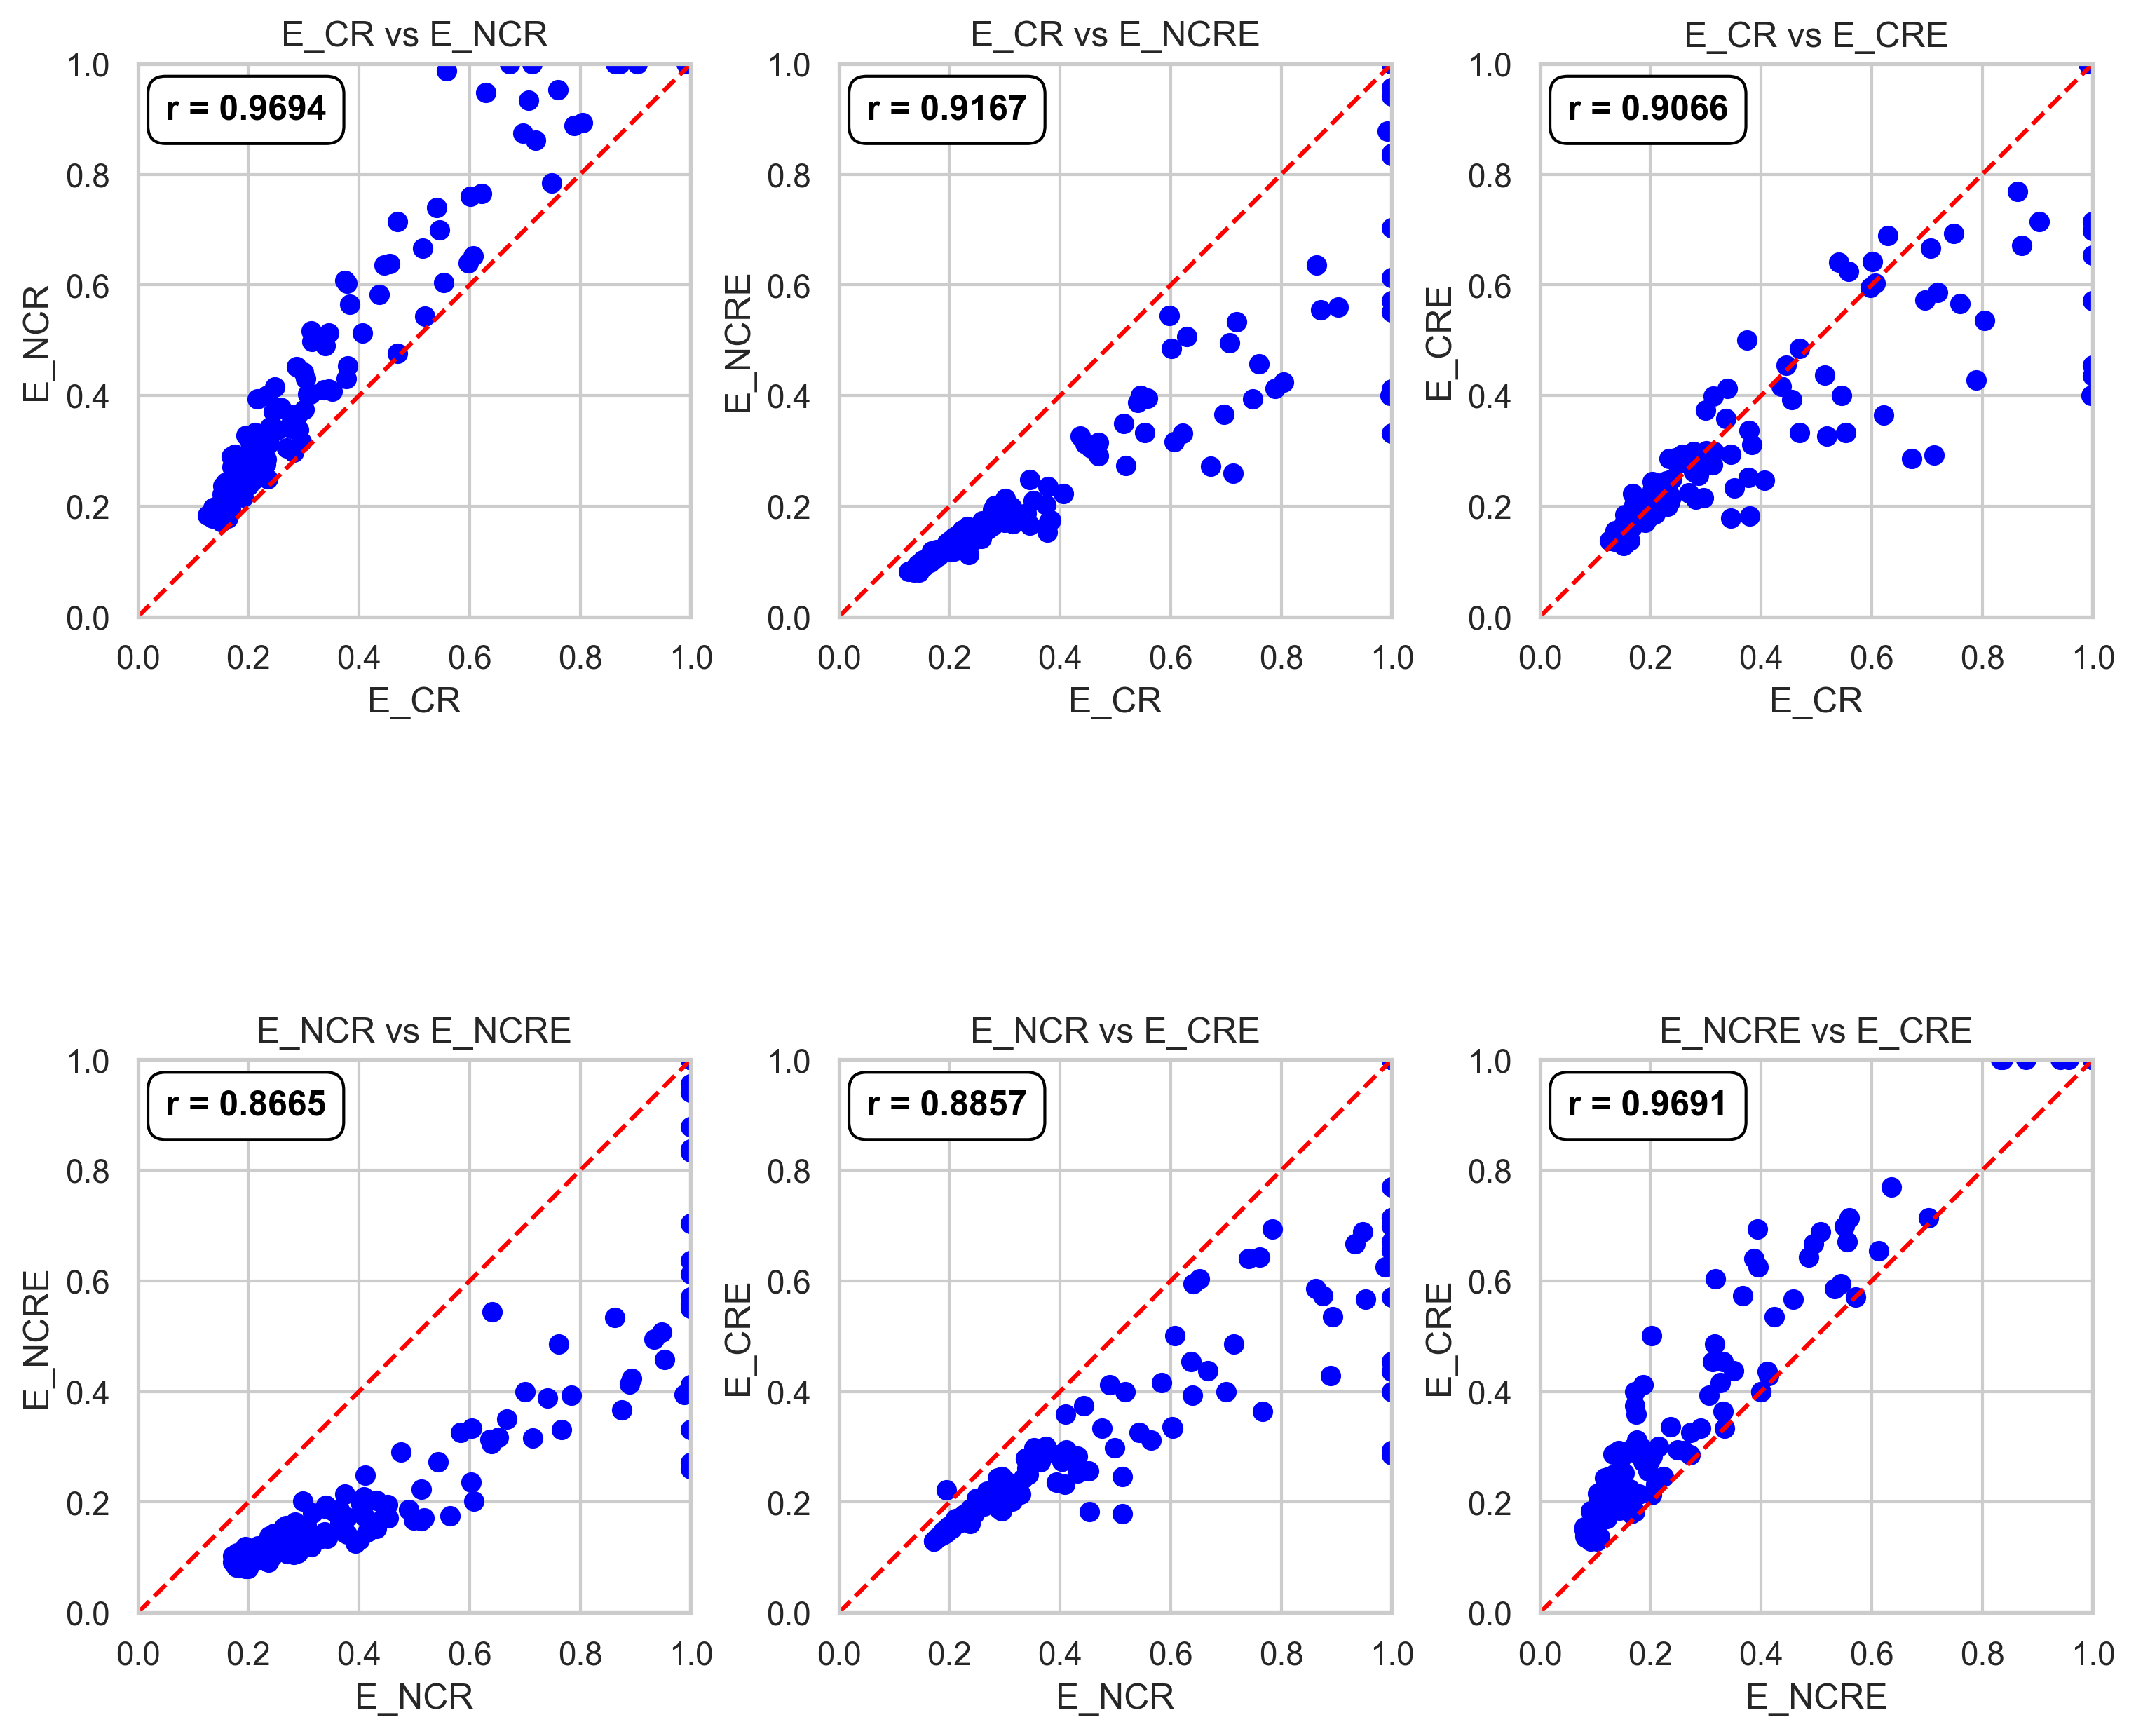

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

pairs = [('E_CR', 'E_NCR'), ('E_CR', 'E_NCRE'), ('E_CR', 'E_CRE'),
         ('E_NCR', 'E_NCRE'), ('E_NCR', 'E_CRE'),
         ('E_NCRE', 'E_CRE')]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 10), dpi=300)  

for i, (var1, var2) in enumerate(pairs, 1):
    plt.subplot(2, 3, i)

    x = dfeff[f'{var1}']
    y = dfeff[f'{var2}']

    plt.scatter(x, y, label=f'{var1} vs {var2}', color='blue')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  

    r = np.corrcoef(x, y)[0, 1]
    plt.text(0.05, 0.9, f'r = {r:.4f}', transform=plt.gca().transAxes,
             fontsize=12, fontweight='bold', color='black',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f'{var1} vs {var2}')

    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout(pad=0.0)  

plt.show()

In [37]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
# CEAT = E_CRE = EAT_FDH
models = ['E_CR', 'E_NCR', 'E_NCRE', 'E_CRE']
results = []

for i in range(len(models)):
    for j in range(i + 1, len(models)):
        M1 = models[i]
        M2 = models[j]
        data1 = dfeff[M1].dropna().values
        data2 = dfeff[M2].dropna().values
        
        ks_stat, p_value = ks_2samp(data1, data2)
        results.append([M1, M2, ks_stat, p_value])

results_df = pd.DataFrame(results, columns=['Model1', 'Model2', 'TKS', 'p-value'])
print(results_df)


   Model1  Model2       TKS       p-value
0    E_CR   E_NCR  0.260000  7.268419e-05
1    E_CR  E_NCRE  0.400000  4.152393e-11
2    E_CR   E_CRE  0.093333  5.321869e-01
3   E_NCR  E_NCRE  0.560000  5.290397e-22
4   E_NCR   E_CRE  0.260000  7.268419e-05
5  E_NCRE   E_CRE  0.393333  9.582445e-11


In [38]:
ks_stat, p_value = ks_2samp(dfeff['E_NCRE'].dropna().values, dfeff['E_NCRE'].dropna().values)
print(ks_stat, p_value)

0.0 1.0
